In [24]:
from pathlib import Path

import pandas as pd
import polars as ps
import seaborn as sb

# Data Preprocessing

## Load Datasets

In [25]:
type_map: list = [ps.Utf8, ps.Utf8, ps.Int32, ps.Utf8, ps.Utf8,
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32,
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32, ps.Float32,
                  ps.Float32, ps.Float32, ps.Float32, ps.Float32,
                  ps.Int32, ps.Datetime, ps.Float32, ps.Float32, ps.Float32, ps.Int32]
null_values: list = ['', '-']

In [26]:
datasets: list = [ps.read_csv(file, encoding='utf8', dtypes=type_map, null_values=null_values, n_threads=8, use_pyarrow=True)
                  for file in Path('data').glob('*.csv')]
dataset: ps.DataFrame = ps.concat(datasets)

## Remove Duplicate Rows and Add New Column

In [27]:
dataset = dataset.unique()
dataset = dataset.with_columns(ps.col('PublishTime').dt.strftime('%Y-%m').alias('PublishYearAndMonth'))

## Convert Non-numerical Data to Numbers

In [28]:
dataset['County'].value_counts(sort=True)

County,counts
str,u32
"""新北市""",193702
"""高雄市""",183183
"""臺北市""",112730
"""桃園市""",92530
"""臺中市""",76110
"""臺南市""",69482
"""雲林縣""",61066
"""彰化縣""",53641
"""屏東縣""",53619


In [29]:
county_type: list = dataset['County'].value_counts(sort=True)['County'].to_list()
county_map: dict = dict(zip(county_type, [i for i in range(len(county_type))]))

In [30]:
dataset = dataset.with_columns(ps.col('County').map_dict(county_map, default='unknown').alias('County').cast(ps.Int32, strict=False))

In [31]:
dataset['Pollutant'].value_counts(sort=True)

Pollutant,counts
str,u32
null,758757
"""細懸浮微粒""",394179
"""臭氧八小時""",46944
"""二氧化氮""",9469
"""懸浮微粒""",8893
"""二氧化硫""",128
"""臭氧""",9
"""一氧化碳""",2


In [32]:
pollutant_type: list = dataset['Pollutant'].value_counts(sort=True)['Pollutant'].to_list()
pollutant_type.remove(None)
pollutant_map: dict = dict(zip(pollutant_type, [i for i in range(len(pollutant_type))]))

In [33]:
dataset = dataset.with_columns(ps.col('Pollutant').map_dict(pollutant_map, default='unknown').alias('Pollutant').cast(ps.Int32, strict=False))

In [34]:
dataset['Status'].value_counts(sort=True)

Status,counts
str,u32
"""良好""",755203
"""普通""",385681
"""對敏感族群不健康""",64309
"""對所有族群不健康""",9610
null,3554
"""非常不健康""",22
"""危害""",2


In [35]:
status_type: list = dataset['Status'].value_counts(sort=True)['Status'].to_list()
status_type.remove(None)
status_map: dict = dict(zip(status_type, [i for i in range(len(status_type))]))

In [36]:
dataset = dataset.with_columns(ps.col('Status').map_dict(status_map, default='unknown').alias('Status').cast(ps.Int32, strict=False))

## Fill Missing Values

In [37]:
dataset.null_count()

SiteName,County,AQI,Pollutant,Status,SO2,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,PM2.5,PM2.5_AVG,NO2,NOx,NO,WindSpeed,WindDirec,PublishTime,SO2_AVG,Longitude,Latitude,SiteId,PublishYearAndMonth
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,4500,758757,3554,26661,28101,17624,37485,22618,27914,16777,24383,13266,31769,31942,31897,268991,268863,0,11399,0,0,0,0


In [38]:
dataset: pd.DataFrame = dataset.to_pandas()

In [39]:
processed_columns: list = ['AQI', 'Pollutant', 'Status', 'WindDirec']
for column in processed_columns:
  dataset[column] = dataset.groupby(['County', 'PublishYearAndMonth'])[column]\
                           .transform(lambda group: group.fillna(group.median()) if not group.isnull().all()
                                                                                 else group.fillna(dataset[column].median()))

In [40]:
processed_columns: list = ['SO2', 'SO2_AVG', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'PM10', 'PM10_AVG', 'PM2.5', 'PM2.5_AVG', 'NO2', 'NOx', 'NO', 'WindSpeed']
for column in processed_columns:
  dataset[column] = dataset.groupby(['County', 'PublishYearAndMonth'])[column]\
                           .transform(lambda group: group.fillna(group.mean()) if not group.isnull().all()
                                                                               else group.fillna(dataset[column].mean()))

In [41]:
dataset: ps.DataFrame = ps.from_pandas(dataset)

In [42]:
type_map.append(ps.Utf8)
type_map[1], type_map[3], type_map[4] = ps.Int32, ps.Int32, ps.Int32
for i, column in enumerate(dataset.columns):
  dataset = dataset.with_columns(ps.col(column).cast(type_map[i], strict=False))
  if type_map[i] is ps.Float32:
    dataset = dataset.with_columns(ps.col(column).round(1))

# Data Analysis

In [43]:
dataset = dataset.drop(['SiteName', 'County', 'PublishYearAndMonth', 'Longitude', 'Latitude'])
dataset = dataset.unique()
dataset = dataset[['SiteId', 'PublishTime', 'AQI', 'Pollutant', 'Status', 'SO2', 'SO2_AVG', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'PM10', 'PM10_AVG', 'NO', 'NO2', 'NOx', 'WindDirec', 'WindSpeed', 'PM2.5', 'PM2.5_AVG']]

In [44]:
dataset.write_csv('full_dataset.csv')

In [45]:
dataset

SiteId,PublishTime,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i32,datetime[μs],i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
5,2022-06-01 00:00:00,26,1,0,0.4,1.0,0.3,0.4,1.1,6.0,16.0,16.0,5.7,15.6,21.299999,136,0.6,10.0,8.0
84,2022-06-01 00:00:00,19,1,0,0.3,0.0,0.1,0.1,19.700001,20.9,21.0,16.0,0.0,5.1,5.1,102,0.4,3.0,2.0
67,2022-06-01 00:00:00,43,1,0,0.5,0.0,1.0,1.4,0.3,1.5,8.0,14.0,25.5,26.9,52.400002,188,1.7,5.0,8.0
16,2022-06-01 02:00:00,36,1,0,0.9,1.0,0.9,2.2,0.0,0.2,17.0,21.0,21.0,16.700001,37.799999,168,1.2,7.0,11.0
54,2022-06-01 03:00:00,25,0,0,1.5,1.0,0.1,0.1,8.4,9.9,12.0,13.0,0.6,15.2,15.9,212,1.3,7.0,6.0
59,2022-06-01 04:00:00,22,0,0,1.7,1.0,0.2,0.2,9.3,8.3,19.0,22.0,0.3,7.4,7.7,97,1.0,4.0,5.0
66,2022-06-01 04:00:00,16,1,0,0.4,0.0,0.1,0.1,8.1,10.2,18.0,16.0,1.2,3.4,4.6,158,0.3,3.0,2.0
34,2022-06-01 04:00:00,39,0,0,1.2,1.0,0.2,0.2,4.8,8.8,24.0,25.0,0.6,9.7,10.4,163,2.6,11.0,12.0
77,2022-06-01 05:00:00,22,0,0,0.3,0.0,0.1,0.0,5.0,9.8,7.0,13.0,0.2,13.1,13.3,223,2.9,2.0,4.0


<Axes: >

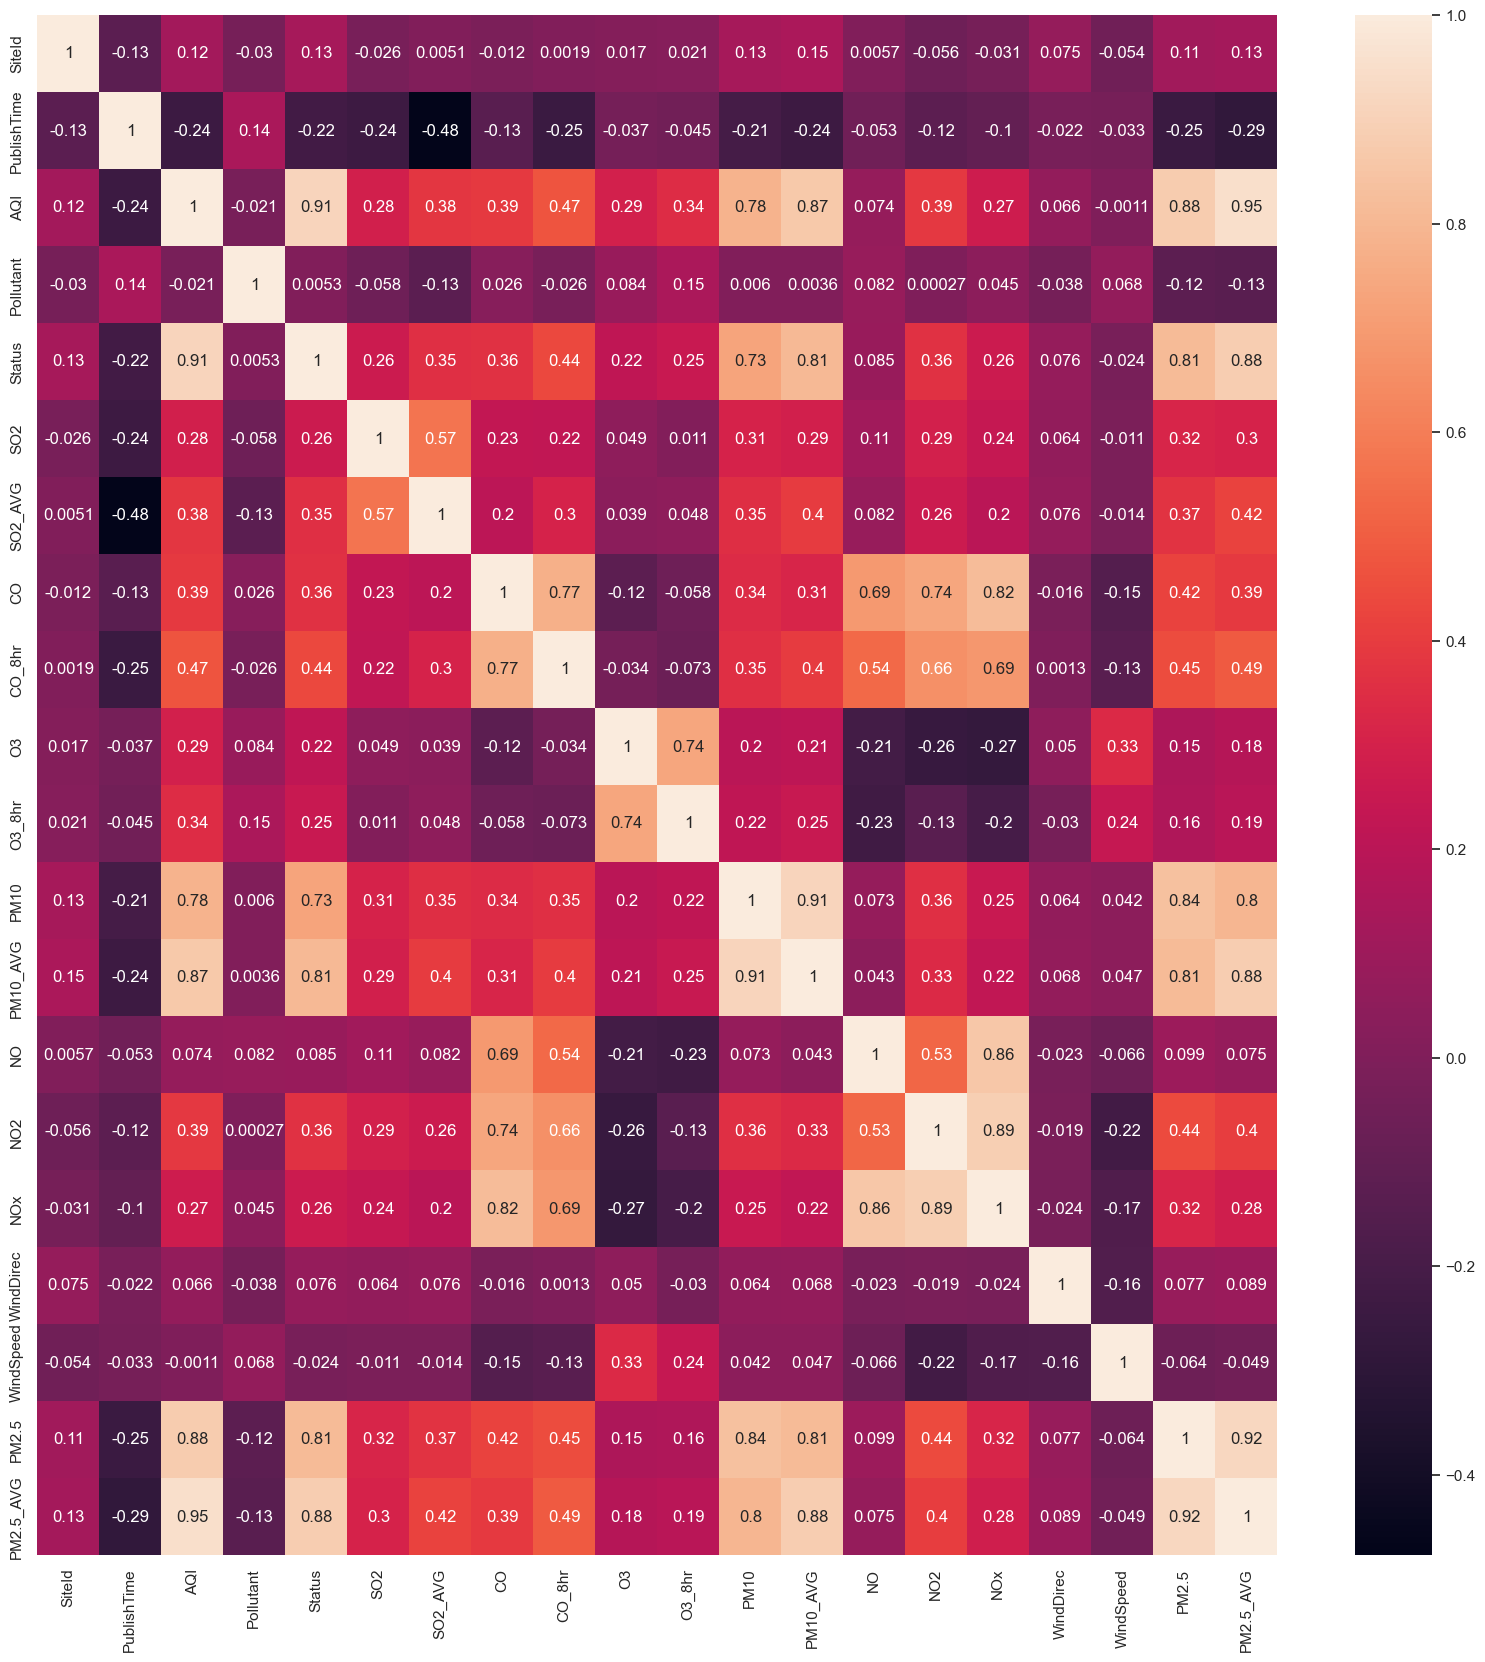

In [46]:
sb.set(rc = {'figure.figsize':(20, 20)})
sb.heatmap(dataset.to_pandas().corr(), annot=True)